Download data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2023-03-18 07:03:02--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.85.72, 13.249.85.10, 13.249.85.7, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.85.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2023-03-18 07:03:02 (41.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian

In [ ]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Polish', 'Scottish', 'German', 'Italian', 'French', 'Russian', 'Vietnamese', 'Korean', 'Spanish', 'English', 'Czech', 'Chinese', 'Japanese', 'Arabic', 'Greek', 'Dutch', 'Irish', 'Portuguese']
O'Neal


Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# RNN #1
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN1, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
# RNN #2
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        
        input_combined = torch.cat((category, input, hidden), 1)
        
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
# RNN #3
class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN3, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        
        input_combined = torch.cat((category, input, hidden), 1)
        
        combined = torch.cat((category, hidden), 1)
        hidden = self.i2h(combined)
        
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
# RNN #4
class RNN4(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN4, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        
        input_combined = torch.cat((category, input, hidden), 1)
        
        hidden = self.i2h(hidden)
        
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [ ]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [ ]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [ ]:
criterion = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor, model, optimizer):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [ ]:
rnn1 = RNN1(n_letters, 128, n_letters)
rnn2 = RNN2(n_letters, 128, n_letters)
rnn3 = RNN3(n_letters, 128, n_letters)
rnn4 = RNN4(n_letters, 128, n_letters)

optimizer1 = torch.optim.Adam(rnn1.parameters())
optimizer2 = torch.optim.Adam(rnn2.parameters())
optimizer3 = torch.optim.Adam(rnn3.parameters())
optimizer4 = torch.optim.Adam(rnn4.parameters())

n_iters = 40000
print_every = 2500
plot_every = 500

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor, model):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset(dataset, model):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate(category_tensor, input_line_tensor, target_line_tensor, model)
            total_loss += loss
    return total_loss / n_instances

def experiment(model, optimizer):

  all_train_losses = []
  all_validation_losses = []
  train_loss = 0 # Reset every plot_every iters

  start = time.time()
  print('\nIter \tTrain% \tTime \t\tTrain_loss')

  for iter in range(1, n_iters + 1):
      output, loss = train(*randomTrainingExample(), model, optimizer)
      train_loss += loss

      if iter % print_every == 0:
          print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

      if iter % plot_every == 0:
          all_train_losses.append(train_loss / plot_every)
          train_loss = 0
          
      # Compute loss based on validation data
      if iter % plot_every == 0:
          average_validation_loss = eval_dataset(validation_data, model)

          # save model with best validation loss
          if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            if model == rnn1:
              torch.save(model, 'char_rnn1_generation_model.pt')
            elif model == rnn2:
              torch.save(model, 'char_rnn2_generation_model.pt')
            elif model == rnn3:
              torch.save(model, 'char_rnn3_generation_model.pt')            
            elif model == rnn4:
              torch.save(model, 'char_rnn4_generation_model.pt')
          
          all_validation_losses.append(average_validation_loss)

  return all_train_losses, all_validation_losses

In [ ]:
print('RNN1 experiment')
all_train_losses_RNN1, all_validation_losses_RNN1 = experiment(rnn1, optimizer1)

RNN1 experiment

Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 23s) 	2.4389
5000 	12% 	(0m 51s) 	2.2996
7500 	18% 	(1m 20s) 	2.2858
10000 	25% 	(1m 46s) 	2.2330
12500 	31% 	(2m 13s) 	2.2538
15000 	37% 	(2m 40s) 	2.2724
17500 	43% 	(3m 7s) 	2.2718
20000 	50% 	(3m 34s) 	2.2442
22500 	56% 	(4m 1s) 	2.2670
25000 	62% 	(4m 27s) 	2.2256
27500 	68% 	(4m 54s) 	2.2144
30000 	75% 	(5m 21s) 	2.1906
32500 	81% 	(5m 47s) 	2.2184
35000 	87% 	(6m 14s) 	2.1904
37500 	93% 	(6m 41s) 	2.1924
40000 	100% 	(7m 8s) 	2.1940


In [ ]:
print('RNN2 experiment')
all_train_losses_RNN2, all_validation_losses_RNN2 = experiment(rnn2, optimizer2)

RNN2 experiment

Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 23s) 	2.4523
5000 	12% 	(0m 51s) 	2.3967
7500 	18% 	(1m 18s) 	2.3311
10000 	25% 	(1m 46s) 	2.3023
12500 	31% 	(2m 13s) 	2.2725
15000 	37% 	(2m 41s) 	2.2602
17500 	43% 	(3m 8s) 	2.2605
20000 	50% 	(3m 35s) 	2.2357
22500 	56% 	(4m 2s) 	2.2263
25000 	62% 	(4m 30s) 	2.2191
27500 	68% 	(4m 57s) 	2.1875
30000 	75% 	(5m 24s) 	2.2821
32500 	81% 	(5m 51s) 	2.2347
35000 	87% 	(6m 18s) 	2.2247
37500 	93% 	(6m 45s) 	2.2253
40000 	100% 	(7m 12s) 	2.1927


In [ ]:
print('RNN3 experiment')
all_train_losses_RNN3, all_validation_losses_RNN3 = experiment(rnn3, optimizer3)

RNN3 experiment

Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 22s) 	2.4635
5000 	12% 	(0m 49s) 	2.4200
7500 	18% 	(1m 15s) 	2.3595
10000 	25% 	(1m 42s) 	2.3201
12500 	31% 	(2m 10s) 	2.3541
15000 	37% 	(2m 41s) 	2.3584
17500 	43% 	(3m 7s) 	2.2985
20000 	50% 	(3m 33s) 	2.3050
22500 	56% 	(4m 1s) 	2.3401
25000 	62% 	(4m 27s) 	2.3271
27500 	68% 	(4m 54s) 	2.3022
30000 	75% 	(5m 20s) 	2.3203
32500 	81% 	(5m 46s) 	2.3176
35000 	87% 	(6m 12s) 	2.3440
37500 	93% 	(6m 38s) 	2.3424
40000 	100% 	(7m 4s) 	2.2820


In [ ]:
print('RNN4 experiment')
all_train_losses_RNN4, all_validation_losses_RNN4 = experiment(rnn4, optimizer4)

RNN4 experiment

Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 21s) 	2.5241
5000 	12% 	(0m 47s) 	2.4446
7500 	18% 	(1m 12s) 	2.3879
10000 	25% 	(1m 37s) 	2.3815
12500 	31% 	(2m 3s) 	2.3181
15000 	37% 	(2m 28s) 	2.3361
17500 	43% 	(2m 54s) 	2.3886
20000 	50% 	(3m 19s) 	2.3245
22500 	56% 	(3m 45s) 	2.3392
25000 	62% 	(4m 11s) 	2.3517
27500 	68% 	(4m 36s) 	2.3440
30000 	75% 	(5m 2s) 	2.3613
32500 	81% 	(5m 27s) 	2.3363
35000 	87% 	(5m 53s) 	2.3224
37500 	93% 	(6m 19s) 	2.2973
40000 	100% 	(6m 45s) 	2.3219


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




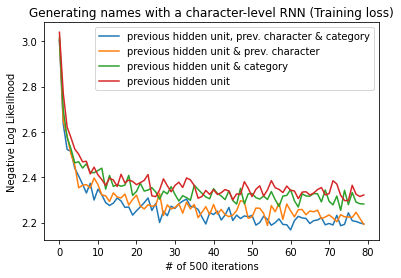

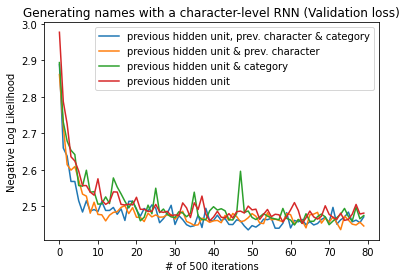

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses_RNN1)
plt.plot(all_train_losses_RNN2)
plt.plot(all_train_losses_RNN3)
plt.plot(all_train_losses_RNN4)
plt.title('Generating names with a character-level RNN (Training loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['previous hidden unit, prev. character & category', 'previous hidden unit & prev. character', 'previous hidden unit & category', 'previous hidden unit'], loc='upper right')

plt.figure()
plt.plot(all_validation_losses_RNN1)
plt.plot(all_validation_losses_RNN2)
plt.plot(all_validation_losses_RNN3)
plt.plot(all_validation_losses_RNN4)
plt.title('Generating names with a character-level RNN (Validation loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['previous hidden unit, prev. character & category', 'previous hidden unit & prev. character', 'previous hidden unit & category', 'previous hidden unit'], loc='upper right')


In [ ]:
# evaluate on test set and print average test loss
rnn1 = torch.load('char_rnn1_generation_model.pt')
average_test_loss_1 = eval_dataset(test_data, rnn1)
print('Average test loss RNN1: ' + str(average_test_loss_1))

rnn2 = torch.load('char_rnn2_generation_model.pt')
average_test_loss_2 = eval_dataset(test_data, rnn2)
print('Average test loss RNN2: ' + str(average_test_loss_2))

rnn3 = torch.load('char_rnn3_generation_model.pt')
average_test_loss_3 = eval_dataset(test_data, rnn3)
print('Average test loss RNN3: ' + str(average_test_loss_3))

rnn4 = torch.load('char_rnn4_generation_model.pt')
average_test_loss_4 = eval_dataset(test_data, rnn4)
print('Average test loss RNN4: ' + str(average_test_loss_4))

Average test loss RNN1: 2.442103224058675
Average test loss RNN2: 2.458011651713632
Average test loss RNN3: 2.462078933106525
Average test loss RNN4: 2.4595002153183003


### Explanation of the results:<br> 

- When we provide just previous hidden unit information to new hidden unit, training, validation and test losses are the highest.
- But, if we provide category information along with previous hidden unit in each hidden unit step, then losses decreases to some extent. However, if we provide previous predicted character information instead of category, it helps hidden unit much more, and our losses decreases significantly.
- And finally, when we provide previous hidden unit, previous predicted character as well as category information in each step of hidden unit, our losses further decreases, and predictions are far superior.
- It is also worth noting here that even when we provide all these information during each step of hidden unit update, our computation time for given number of iterations is not much changing. So, we can go with this hidden unit update approach for further text generation tasks. Providing category, previous character and previous hidden unit information helps model converge faster due to context availability at each step, and this helps it deal better with short term memory and vanishing gradients problems that happens otherwise.

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn1.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn1(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovekinn
Uriski
Shimans
Gras
Eleres
Romen
Sallo
Palla
Abero
Can
Hun
Ino


Exercises
=========

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the nn.LSTM and nn.GRU layers
   -  Combine multiple of these RNNs as a higher level network


